In [26]:
! pip install tensorflow-addons
! pip install imblearn

In [27]:
from keras.utils.np_utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa

from keras.utils import vis_utils, to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

from dataset import load_data, test, train, classes

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


### Data Pre-Processing

In [28]:
x_train_img, y_train = load_data(train)
print(np.amax(y_train), x_train_img.shape, y_train.shape, y_train, len(np.unique(y_train)), classes)
x_test_img, y_test = load_data(test)


1 (1079, 256, 256) (1079, 5) [[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]] 2 ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']


In [29]:
CLASSES = classes

n_train, rows_train, cols_train = x_train_img.shape
x_train_img = x_train_img.reshape((n_train, rows_train, cols_train, 1))
n_test, rows_test, cols_test = x_test_img.shape
x_test_img = x_test_img.reshape((n_test, rows_test, cols_test, 1))

IMG_SIZE = rows_train

In [30]:
# #Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP,
    width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=ZOOM, brightness_range=BRIGHT_RANGE)

train_data_gen = work_dr.flow(x=x_train_img, y=y_train, batch_size = 1079)

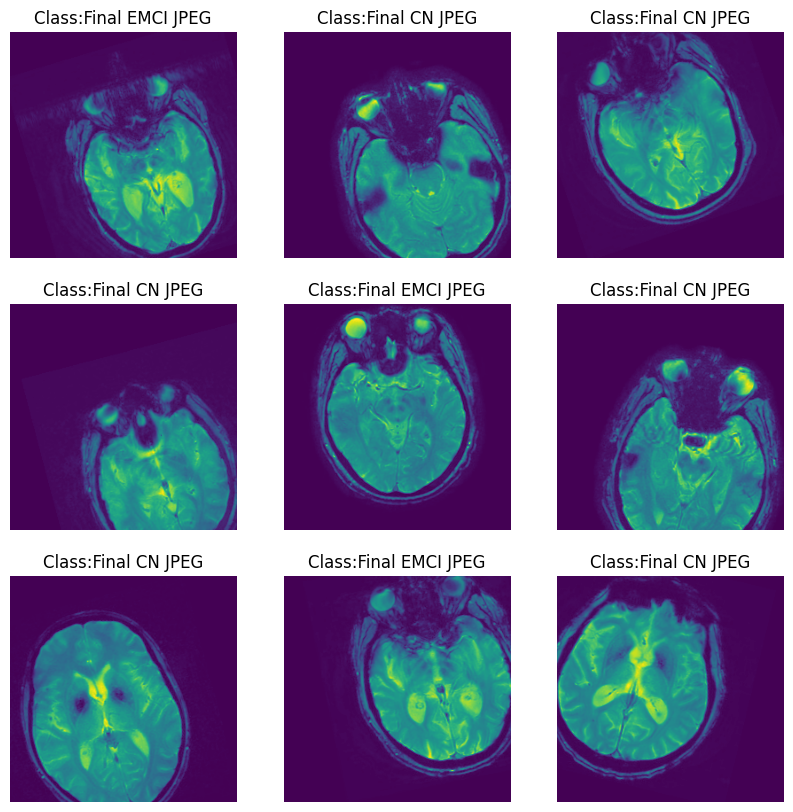

In [31]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3, 4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 199)
            plt.imshow(x[idx].reshape(256, 256))
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [32]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [33]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(1079, 256, 256, 1) (1079, 5)


In [35]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42, k_neighbors = 3)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE)

print(train_data.shape, train_labels.shape)

(2460, 256, 256) (2460, 5)


In [36]:
#Splitting the data into train, test, and validation sets

test_data, test_labels = x_test_img, y_test
# train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Constructing a Convolutional Neural Network Architecture

In [37]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [38]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [39]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*[IMG_SIZE,IMG_SIZE], 1)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(5, activation='softmax')        
    ], name = "cnn_model")

    return model

In [40]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [41]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=5)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 sequential_7 (Sequential)   (None, 64, 64, 32)        14016     
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 64)        55680     
                                                                 
 sequential_9 (Sequential)   (None, 16, 16, 128)       221952    
                                                         

### Training & Testing the Model

In [42]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 10

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
62/62 [==============================] - 290s 4s/step - loss: 2.1757 - acc: 0.2205 - auc: 0.5331 - f1_score: 0.2199 - val_loss: 1.7788 - val_acc: 0.2093 - val_auc: 0.4876 - val_f1_score: 0.0692
Epoch 2/10
62/62 [==============================] - 317s 5s/step - loss: 2.0189 - acc: 0.2195 - auc: 0.5290 - f1_score: 0.2189 - val_loss: 1.9269 - val_acc: 0.1992 - val_auc: 0.5195 - val_f1_score: 0.1328
Epoch 3/10
62/62 [==============================] - 327s 5s/step - loss: 1.9056 - acc: 0.2378 - auc: 0.5430 - f1_score: 0.2366 - val_loss: 2.9903 - val_acc: 0.2093 - val_auc: 0.5045 - val_f1_score: 0.0692
Epoch 4/10
62/62 [==============================] - 283s 5s/step - loss: 1.8214 - acc: 0.2312 - auc: 0.5524 - f1_score: 0.2310 - val_loss: 2.2829 - val_acc: 0.2134 - val_auc: 0.5122 - val_f1_score: 0.0860
Epoch 5/10
62/62 [==============================] - 339s 5s/step - loss: 1.7163 - acc: 0.2683 - auc: 0.5761 - f1_score: 0.2681 - val_loss: 2.3405 - val_acc: 0.2093 - val_auc: 0.514

In [43]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

6/6 [==============================] - 9s 1s/step - loss: 102.2001 - acc: 0.4531 - auc: 0.6582 - f1_score: 0.1252
Testing Accuracy: 45.31%


In [44]:
#Predicting the test data

pred_labels = model.predict(test_data)

6/6 [==============================] - 9s 1s/step


In [45]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.00      0.00      0.00        23
  Final CN JPEG       0.46      1.00      0.63        87
Final EMCI JPEG       0.00      0.00      0.00        36
Final LMCI JPEG       0.00      0.00      0.00        11
 Final MCI JPEG       0.00      0.00      0.00        35

      micro avg       0.45      0.45      0.45       192
      macro avg       0.09      0.20      0.13       192
   weighted avg       0.21      0.45      0.28       192
    samples avg       0.45      0.45      0.45       192



C:\Users\kcooo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


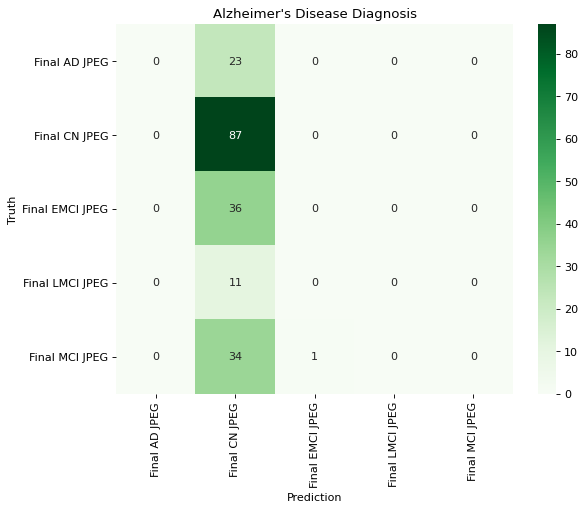

In [46]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [47]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 20.0 %
Matthew's Correlation Coefficient: 1.61 %


In [48]:
#Saving the model for future use

# model_dir = work_dir + "alzheimer_cnn_model"
# model.save(model_dir, save_format='h5')
# os.listdir(work_dir)

In [49]:
# pretrained_model = tf.keras.models.load_model(model_dir)

# #Check its architecture
# visu_utils.plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

### Using the InceptionV3 model as a base model for the task

**Please check out the notebook here: 
[Inception V3 Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-inceptionv3)**